In [1]:
from ultralytics import YOLO
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

import os
import csv


is_save = False
extract = True
comp_filter_size = 160


def crop_left(im): 
    return transforms.functional.crop(im, top=0, left=0, height=320, width=500)


class FeatureExtractor:
    def __init__(self, model, device='cuda:0'):
        self.model = model
        self.features = []
        self.device = device

        # Define a downsampling layer
        self.downsample = nn.Sequential(
            nn.Conv2d(512, comp_filter_size, kernel_size=1, stride=1),  # Reducing channels from 576 to 256
            # nn.ReLU(),
            # nn.AdaptiveAvgPool2d((16, 16))  # Reducing spatial dimensions to 10x10
        ).to(self.device)

    def hook(self, module, input, output):
        print(f"Hook called for layer: {module}")
        # Apply downsampling
        output = output.to(self.device)
        downsampled_output = self.downsample(output)
        self.features.append(downsampled_output)

    def register_hooks(self, layer_names):
        self.hooks = []
        for name, module in self.model.model.named_modules():  # Adjusted for YOLOv8 specific submodule access
            if name in layer_names:
                print(f"Registering hook for layer: {name}")
                hook = module.register_forward_hook(self.hook)
                self.hooks.append(hook)

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def extract_features(self, img_path):
        self.features = []
        img = Image.open(img_path).convert('RGB')  # Load image using PIL
        transform = transforms.Compose([
            transforms.Lambda(crop_left),  # Crop the left side
            transforms.Pad(padding=(70, 160, 70, 160)),  # Pad to 640x640
            transforms.ToTensor()
        ])
        img = transform(img).unsqueeze(0).to(self.device)
        self.model(img)
        return self.features

In [2]:
device = 'cuda:0'
t_steps = 400
dims = 1#128 * 20 * 20
feats = torch.zeros(1, dims)
trajs = torch.zeros(1, t_steps, 3)

# model = YOLO('yolov8l.pt').to(device)
# feature_extractor = FeatureExtractor(model, device=device)

# layer_names = ['model.21']
# feature_extractor.register_hooks(layer_names)

# img_path = f'data/0/0/img.jpeg'
# features = feature_extractor.extract_features(img_path)
# feats[0] = features[0].view(-1)
feats[0] = 0

In [3]:
import sys
import torch
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns


folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnep import CNEP
from cnmp import CNMP

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [4]:
num_demos, v_num_demos = 1, 1
num_classes = 1  # Number of modes
num_indiv = num_demos // num_classes  # Number of trajectories per mode
num_val_indiv = v_num_demos // num_classes  # Number of trajectories per mode

dx = 1
dg = dims
dy = 3
batch_size = 1
n_max, m_max = 10, 10
t_steps = 400

In [5]:
obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx+dg), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = trajs[traj_id]
        feat = feats[traj_id]
        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)  # X
        obs[i, :n, dx:dx+dg] = feat.repeat(n, 1)  # G
        obs[i, :n, dx+dg:] = traj[n_ids]  # Y
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dx] = (m_ids/t_steps).unsqueeze(1)
        tar_x[i, :m, dx:] = feat.repeat(m, 1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = trajs[traj_id]
        feat = feats[traj_id]
        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:dx+dg] = feat.repeat(n, 1)
        val_obs[i, :n, dx+dg:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i, :, :dx] = (m_ids/t_steps).unsqueeze(1)
        val_tar_x[i, :, dx:] = feat.repeat(t_steps, 1)
        val_tar_y[i] = traj[m_ids]

In [6]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_type = 'baxter/'
test_path = 'cnmp_cnep_0_1_feat/1718609578/'
run_path = root_path + test_type + test_path

In [7]:
model_folder = 'saved_models/'
models_path = f'{run_path}{model_folder}'

cnep_path, cnmp_path = f'{models_path}cnep.pt', f'{models_path}cnmp.pt'

batch_size = 1
device = 'cpu'

cnep = CNEP(dx+dg, dy, n_max, n_max, [512, 128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnmp = CNMP(dx+dg, dy, n_max, m_max, [512, 128], decoder_hidden_dims=[256, 256], batch_size=batch_size, device=device)

cnep.load_state_dict(torch.load(cnep_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(cnmp_path, map_location='cpu'))

# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

In [8]:
t_steps = 400
val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)
###############
m = 2
val_obs_mask[0, :m] = True
val_tar_x[0, :, 0] = torch.linspace(0, 1, t_steps)
val_tar_x[0, :, 1:dx+dg] = feats[0].repeat(t_steps, 1)
###############
val_obs[0, 0, 0] = 0
val_obs[0, 0, 1:dx+dg] = feats[0]
val_obs[0, 0, dx+dg:] = torch.tensor([0.647,-0.8414, 0.046])
val_obs[0, 1, 0] = 1
val_obs[0, 1, 1:dx+dg] = feats[0]
val_obs[0, 1, dx+dg:] = torch.tensor([0.45, -0.956, 0.02])


with torch.no_grad():
    pred_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)
    traj_cnmp = pred_cnmp[0, :, :dy]

    pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
    dec_id = torch.argmax(gate.squeeze(1), dim=-1)
    traj_cnep = pred_cnep[dec_id, 0, :, :dy]

In [9]:
# feature_extractor.remove_hooks()

In [10]:
traj_cnep.shape

torch.Size([1, 400, 3])

In [11]:
# interpolate traj_cnmp (400x3) to 1159x3 points
from scipy.interpolate import interp1d

x = np.linspace(0, 1, 400)
f = interp1d(x, traj_cnmp.squeeze(0), axis=0)
xnew = np.linspace(0, 1, 1370)
traj_cnmp_interpolated = f(xnew)
# interpolate traj_cnep (400x3) to 1159x3 points
f = interp1d(x, traj_cnep.squeeze(0), axis=0)
traj_cnep_interpolated = f(xnew)

t_steps_int = 1370

with open('data/current/cnmp.txt', 'w') as f:
    for i in range(t_steps_int):
        f.write(f'{traj_cnmp_interpolated[i, 0].item()},{traj_cnmp_interpolated[i, 1].item()},{traj_cnmp_interpolated[i, 2].item()}\n')

with open('data/current/cnep.txt', 'w') as f:
    for i in range(t_steps_int):
        f.write(f'{traj_cnep_interpolated[i, 0].item()},{traj_cnep_interpolated[i, 1].item()},{traj_cnep_interpolated[i, 2].item()}\n')

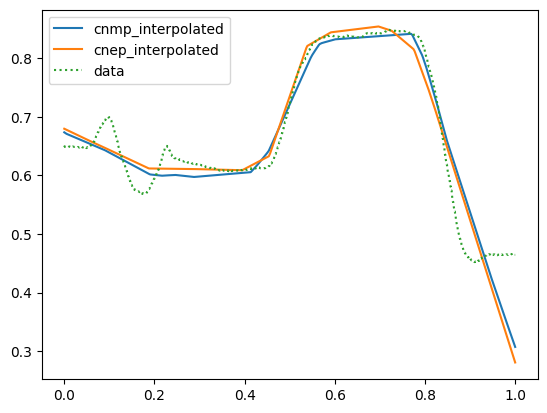

In [12]:
data_folder = f'/home/yigit/projects/cnep/baxter/data/0/0/'
# iterate over all files in the data_folder
for filename in os.listdir(data_folder):
    d = os.path.join(data_folder, filename)
    if filename.endswith('.csv'):
        temp_data = []
        with open(d, 'r') as f:
            for j, line in enumerate(csv.reader(f)):
                if j > 0:
                    # temp_data.append([float(line[3]), float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[8]), float(line[9]), (float(line[10])/50)-1])  # p, q, gripper
                    temp_data.append([float(line[3]), float(line[4]), float(line[5])])  # p

# plot traj_cnep[0, :, 0] in torch.linspace(0, 1, t_steps) and traj_cnep_interpolated[:, 0] in torch.linspace(0, 1, t_steps_int) and temp_data[:, 0] in torch.linspace(0, 1, len(temp_data))
# plt.plot(torch.linspace(0, 1, t_steps), traj_cnep[0, :, 0], label='cnep', linestyle='--')
plt.plot(torch.linspace(0, 1, t_steps_int), traj_cnmp_interpolated[:, 0], label='cnmp_interpolated')
plt.plot(torch.linspace(0, 1, t_steps_int), traj_cnep_interpolated[:, 0], label='cnep_interpolated')
plt.plot(torch.linspace(0, 1, len(temp_data)), [x[0] for x in temp_data], label='data', linestyle=':')
plt.legend()
plt.show()